# Parseo de file .dat

In [6]:
PARSE_SCRIPT = "./parse.sh"
!chmod +x {PARSE_SCRIPT}

def csv_from_dat(dat_file):
  !{PARSE_SCRIPT} {dat_file + ".dat"}

In [13]:
dat_file = "./files/SanEmidio_3D_Model/InputData/Faults/1"
csv_from_dat(dat_file)

writing to .csv


# Csv a dataframe

In [55]:
#!pip3 install pandas
import pandas as pd

columns= ['x', 'y', 'z', 'faultid', 'lineid']
dataframe = pd.read_csv("./fault_1_parse.csv", header=None, names = columns)

dataframe

,x,y,z,faultid,lineid
0,297022.403131,4.474000e+06,682.399668,1.0,SectionC
1,297650.194000,4.473987e+06,1388.381592,1.0,SectionC
2,295104.806600,4.475887e+06,-2217.032318,1.0,SectionD
3,297521.932164,4.475970e+06,1258.264909,NaN,SectionD
4,297478.412315,4.475970e+06,1197.340614,NaN,SectionD
...,...,...,...,...,...
6532,299960.799207,4.465229e+06,3007.799389,NaN,helper
6533,300651.791281,4.465229e+06,3753.903179,NaN,helper
6534,297604.400271,4.471776e+06,1262.790176,NaN,SectionA
6535,297592.673408,4.471776e+06,1252.805809,NaN,SectionA


# Ploteo de dataframe

In [34]:
# Import libraries
from mpl_toolkits import mplot3d
import numpy as np
import matplotlib.pyplot as plt

def plot_dataframe(dataframe):
    # Data from dataset
    z = dataframe['z']
    x = dataframe['x']
    y = dataframe['y']

    # Creating figure
    fig = plt.figure(figsize = (20, 13))
    ax = plt.axes(projection ="3d")

    # Add x, y gridlines 
    ax.grid(b = True, color ='grey', 
            linestyle ='-.', linewidth = 0.3, 
            alpha = 0.2) 


    # Creating color map
    my_cmap = plt.get_cmap('hsv')

    # Creating plot
    sctt = ax.scatter3D(x, y, z,
                        alpha = 0.8,
                        c = (x + y + z), 
                        cmap = my_cmap, 
                        marker ='o')

    plt.title("simple 3D scatter plot")
    ax.set_xlabel('X-axis', fontweight ='bold') 
    ax.set_ylabel('Y-axis', fontweight ='bold') 
    ax.set_zlabel('Z-axis', fontweight ='bold')
    fig.colorbar(sctt, ax = ax, shrink = 0.5, aspect = 5)

    # show plot
    plt.show()

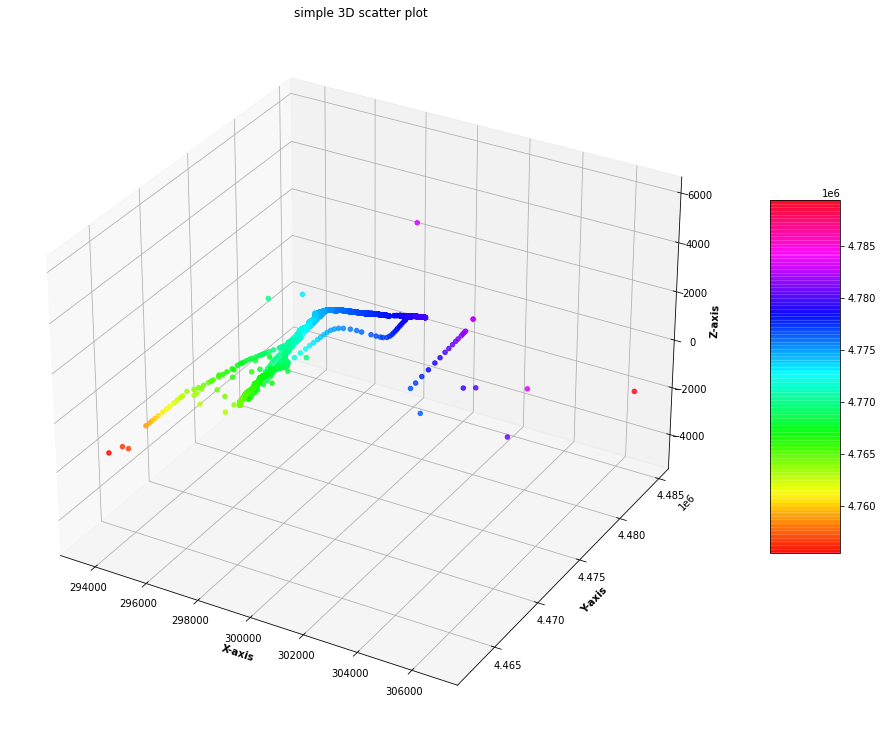

In [35]:
plot_dataframe(dataframe)

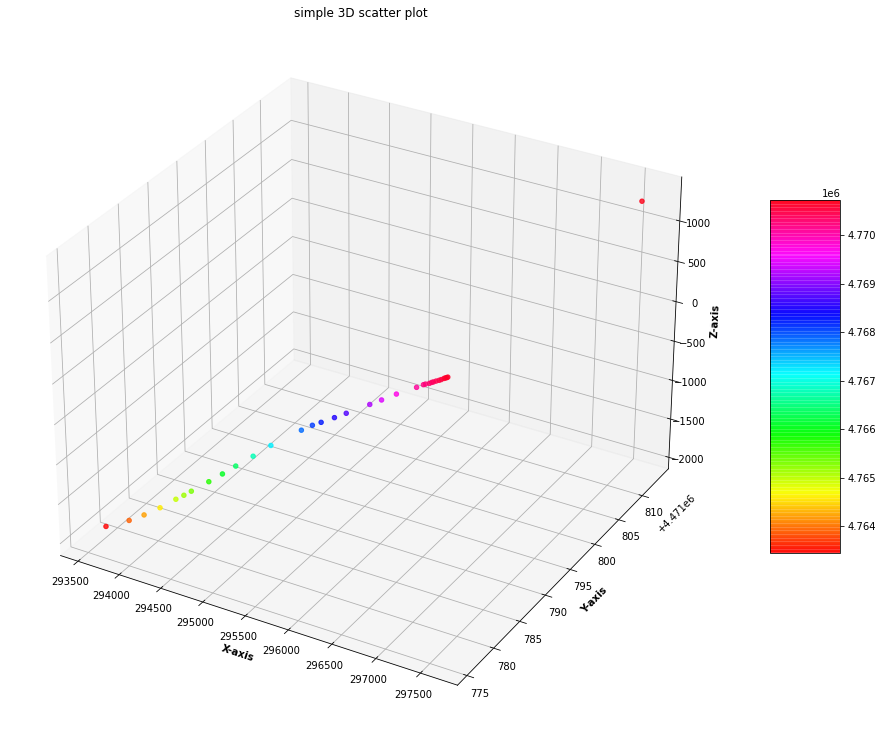

In [37]:
plot_dataframe(dataframe[dataframe['lineid']=="SectionA"])

In [29]:
coords = dataframe[['x','y','z']]
coords

,x,y,z
0,297022.403131,4.474000e+06,682.399668
1,297650.194000,4.473987e+06,1388.381592
2,295104.806600,4.475887e+06,-2217.032318
3,297521.932164,4.475970e+06,1258.264909
4,297478.412315,4.475970e+06,1197.340614
...,...,...,...
6532,299960.799207,4.465229e+06,3007.799389
6533,300651.791281,4.465229e+06,3753.903179
6534,297604.400271,4.471776e+06,1262.790176
6535,297592.673408,4.471776e+06,1252.805809


# Funciones para hacer la SDF

## Forma ineficiente

In [58]:
from math import sqrt


def distanceSquared3D(point, other):
    return sqrt((point[0]-other[0])**2 + (point[1]-other[1])**2 + (point[2]-other[2])**2)


# def isInSphere(spheres, point):
#     for sphere in spheres:
#         if distanceSquared3D(point, sphere[0])< sphere[1]**2:
#             return True
#     return False


# def spheres(coord_and_dist, coordinates_file, distances_file, width, height, max_spheres):  
#     coordinates_spheres = [] #[(Point,r)]
#     for i in range(len(coord_and_dist)):
#         distance = coord_and_dist[i][1]
#         if (distance > 0 and len(coordinates_spheres) < max_spheres):
#             coordinates = coord_and_dist[i][0]
#             coord = (coordinates[0], coordinates[1], coordinates[2])
#             if(not isInSphere(coordinates_spheres, coord)):
#                 coordinates_spheres.append((coord, distance))

#     return coordinates_spheres


def getDistance(x, y, z, index, internalValue="SectionA"):
    coords = dataframe[['x','y','z','lineid']]
    
    realInternalValue = dataframe.loc[index]['lineid']
    # coords.drop([index]) --> not necesary
    
    if realInternalValue == internalValue:
        # filtrar coords: quedarme con los distintos a internalValue
        coords = coords[coords['lineid']!=internalValue]
    else:
        # filtrar coords: quedarme con los de igual a internalValue
        coords = coords[coords['lineid']==internalValue]
    
    distances = []
    for index, row in coords.iterrows():            
        distances.append(distanceSquared3D((x,y,z),(float(row['x']), float(row['y']), float(row['z']))))
    
    min_distance = min(distances)
    if realInternalValue == internalValue:
        return -(min_distance) #hay que restarle 1? que significa ese 1? 
        
    return min_distance
        
    
def dataframe_to_sdf(dataframe): #columns = [x, y, z, faultid, lineid]
    for index, row in dataframe.iterrows():
        distance = getDistance(float(row['x']), float(row['y']), float(row['z']), index)
        dataframe.at[index, 'distance'] = distance
    return dataframe

In [59]:
import time

initial_time=time.time()
sdf = dataframe_to_sdf(dataframe)
end_time=time.time()
print("Calcularlo con 'iterrows' tardo {} segundos".format(end_time-initial_time))
sdf

Calcularlo con 'iterrows' tardo 67.11397218704224 segundos


,x,y,z,faultid,lineid,distance
0,297022.403131,4.474000e+06,682.399668,1.0,SectionC,2229.827253
1,297650.194000,4.473987e+06,1388.381592,1.0,SectionC,2175.525773
2,295104.806600,4.475887e+06,-2217.032318,1.0,SectionD,4267.110458
3,297521.932164,4.475970e+06,1258.264909,NaN,SectionD,4158.085116
4,297478.412315,4.475970e+06,1197.340614,NaN,SectionD,4160.483223
...,...,...,...,...,...,...
6532,299960.799207,4.465229e+06,3007.799389,NaN,helper,7173.478216
6533,300651.791281,4.465229e+06,3753.903179,NaN,helper,7638.936613
6534,297604.400271,4.471776e+06,1262.790176,NaN,SectionA,-42.915690
6535,297592.673408,4.471776e+06,1252.805809,NaN,SectionA,-57.442993


## Forma mas eficiente

In [25]:
# Using 'map' function
from math import sqrt


def distanceSquared3D(point, other):
    return sqrt((point[0]-other[0])**2 + (point[1]-other[1])**2 + (point[2]-other[2])**2)


def getDistance(x, y, z, realInternalValue, internalValue = "SectionA", columns = ['x','y','z','lineid']):
    coords = dataframe[columns]
        
    if realInternalValue == internalValue:
        # filtrar coords: quedarme con los distintos a internalValue
        coords = coords[coords[columns[3]]!=internalValue]
    else:
        # filtrar coords: quedarme con los de igual a internalValue
        coords = coords[coords[columns[3]]==internalValue]
    
    distances = coords.apply(lambda row: distanceSquared3D((x,y,z),(float(row[columns[0]]), float(row[columns[1]]), float(row[columns[2]]))), axis=1)
       
    min_distance = distances.min()
    if realInternalValue == internalValue:
        return -(min_distance)
    
    print(min_distance)
    return min_distance
        
    
def dataframe_to_sdf(dataframe, internalValue = "SectionA", columns = ['x','y','z','lineid']): #columns = [x, y, z, faultid, lineid]
    dataframe["distance"] = dataframe.apply(lambda x: getDistance(x[columns[0]], x[columns[1]], x[columns[2]], x[columns[3]], internalValue, columns), axis=1)
    return dataframe

In [57]:
import time

initial_time=time.time()
sdf = dataframe_to_sdf(dataframe)
end_time=time.time()
print("Calcularlo con 'map' tardo {} segundos".format(end_time-initial_time))
sdf

Calcularlo con 'map' tardo 27.960976362228394 segundos


,x,y,z,faultid,lineid,distance
0,297022.403131,4.474000e+06,682.399668,1.0,SectionC,2229.827253
1,297650.194000,4.473987e+06,1388.381592,1.0,SectionC,2175.525773
2,295104.806600,4.475887e+06,-2217.032318,1.0,SectionD,4267.110458
3,297521.932164,4.475970e+06,1258.264909,NaN,SectionD,4158.085116
4,297478.412315,4.475970e+06,1197.340614,NaN,SectionD,4160.483223
...,...,...,...,...,...,...
6532,299960.799207,4.465229e+06,3007.799389,NaN,helper,7173.478216
6533,300651.791281,4.465229e+06,3753.903179,NaN,helper,7638.936613
6534,297604.400271,4.471776e+06,1262.790176,NaN,SectionA,-42.915690
6535,297592.673408,4.471776e+06,1252.805809,NaN,SectionA,-57.442993


In [32]:
# distances NaN
sdf[sdf["distance"].isna()]

,x,y,z,faultid,lineid,distance


In [33]:
# distances not NaN
sdf[sdf["distance"].notna()]

,x,y,z,faultid,lineid,distance
0,297022.403131,4.474000e+06,682.399668,1.0,SectionC,2229.827253
1,297650.194000,4.473987e+06,1388.381592,1.0,SectionC,2175.525773
2,295104.806600,4.475887e+06,-2217.032318,1.0,SectionD,4267.110458
3,297521.932164,4.475970e+06,1258.264909,NaN,SectionD,4158.085116
4,297478.412315,4.475970e+06,1197.340614,NaN,SectionD,4160.483223
...,...,...,...,...,...,...
6532,299960.799207,4.465229e+06,3007.799389,NaN,helper,7173.478216
6533,300651.791281,4.465229e+06,3753.903179,NaN,helper,7638.936613
6534,297604.400271,4.471776e+06,1262.790176,NaN,SectionA,-42.915690
6535,297592.673408,4.471776e+06,1252.805809,NaN,SectionA,-57.442993


In [46]:
dataframe[dataframe['lineid']!="SectionC"]

,x,y,z,faultid,lineid,distance
2,295104.806600,4.475887e+06,-2217.032318,1.0,SectionD,4267.110458
3,297521.932164,4.475970e+06,1258.264909,NaN,SectionD,4158.085116
4,297478.412315,4.475970e+06,1197.340614,NaN,SectionD,4160.483223
5,297440.928937,4.475970e+06,1144.042990,NaN,SectionD,4163.659180
6,297414.566727,4.475970e+06,1099.622684,NaN,SectionD,4166.842007
...,...,...,...,...,...,...
6532,299960.799207,4.465229e+06,3007.799389,NaN,helper,7173.478216
6533,300651.791281,4.465229e+06,3753.903179,NaN,helper,7638.936613
6534,297604.400271,4.471776e+06,1262.790176,NaN,SectionA,-42.915690
6535,297592.673408,4.471776e+06,1252.805809,NaN,SectionA,-57.442993


In [45]:
dataframe.loc[2]['lineid'] == "SectionD"

True

# Generacion de cubo de tierra (datos)

In [5]:
!pip install noise

Defaulting to user installation because normal site-packages is not writeable
     |████████████████████████████████| 132 kB 260 kB/s eta 0:00:01
  Created wheel for noise: filename=noise-1.2.2-cp36-cp36m-linux_x86_64.whl size=63141 sha256=2255fc6087ddd912ab7e9b826d77ab9e4d4f135751da1f1fa15f6e319137b4cb
  Stored in directory: /home/flor/.cache/pip/wheels/87/b5/ac/66d3c433a3acce26f10c43ba496088af1d940f4da051985c51
Successfully built noise
You should consider upgrading via the '/usr/bin/python3 -m pip install --upgrade pip' command.


In [6]:
import numpy as np
import noise

def generate_terrain():
    shape = (20, 20, 20)
    scale = 100.0
    octaves = 6
    persistence = 0.5
    lacunarity = 2.0

    world = np.zeros(shape)

    for i in range(shape[0]):
        for j in range(shape[1]):
            for k in range(shape[2]):
                density = noise.pnoise3(i / scale,
                                        j / scale,
                                        k / scale,
                                        octaves=octaves,
                                        persistence=persistence,
                                        lacunarity=lacunarity,
                                        repeatx=1024,
                                        repeaty=1024,
                                        repeatz=1024,
                                        base=42)
                world[i][j][k] = density

    #plot_dataframe(world)
    return world

In [7]:
terrain = generate_terrain()

In [10]:
terrain

array([[[0.        , 0.03258603, 0.0618329 , ..., 0.23677659,
         0.22908203, 0.23123303],
        [0.00326539, 0.03349958, 0.06179116, ..., 0.23497878,
         0.23004799, 0.23200431],
        [0.01080146, 0.03402521, 0.06090566, ..., 0.22904588,
         0.22667468, 0.22599192],
        ...,
        [0.06841178, 0.0551392 , 0.04430683, ..., 0.23193453,
         0.23161632, 0.2364942 ],
        [0.07256555, 0.06019788, 0.05213081, ..., 0.23015973,
         0.22912113, 0.23407307],
        [0.07774235, 0.06595241, 0.06102517, ..., 0.23576322,
         0.23336886, 0.23780766]],

       [[0.03258603, 0.06004842, 0.08003891, ..., 0.23510319,
         0.22625324, 0.22831614],
        [0.03446553, 0.06065301, 0.08070825, ..., 0.23241767,
         0.22653168, 0.22838107],
        [0.03747283, 0.06039054, 0.08373598, ..., 0.22481708,
         0.22253768, 0.22176737],
        ...,
        [0.07415111, 0.06217201, 0.05086714, ..., 0.24214798,
         0.24082111, 0.24386434],
        [0.0

## Funcion para pasar de matriz a dataframe

In [17]:
def using_multiindex(A, columns):
    shape = A.shape
    index = pd.MultiIndex.from_product([range(s)for s in shape], names=columns)
    df = pd.DataFrame({'A': A.flatten()}, index=index).reset_index()
    return df

In [18]:
dataframe_terrain = using_multiindex(terrain, list('ZYX'))

In [24]:
dataframe_terrain

,Z,Y,X,A
0,0,0,0,0.000000
1,0,0,1,0.032586
2,0,0,2,0.061833
3,0,0,3,0.082446
4,0,0,4,0.097867
...,...,...,...,...
7995,19,19,15,0.377797
7996,19,19,16,0.366430
7997,19,19,17,0.352210
7998,19,19,18,0.334525


In [27]:
dataframe_terrain[['Z']]

,Z
0,0
1,0
2,0
3,0
4,0
...,...
7995,19
7996,19
7997,19
7998,19


In [58]:
from math import sqrt


def distanceSquared3D(point, other):
    return sqrt((point[0]-other[0])**2 + (point[1]-other[1])**2 + (point[2]-other[2])**2)


def getDistance(x, y, z, realInternalValue, internalValue = [0,1], columns = ['x','y','z','lineid']):
    coords = dataframe[columns]
    #print("internalValue: {} - realInternalValue: {}".format(internalValue, realInternalValue))
    
    realInternalValueIsAnInternalValue = internalValue[0] <= realInternalValue <= internalValue[1]
    print(realInternalValueIsAnInternalValue)
    if realInternalValueIsAnInternalValue:
        # filtrar coords: quedarme con los distintos a internalValue
        coords = coords[~coords[columns[3]].between(internalValue[0], internalValue[1])]
    else:
        # filtrar coords: quedarme con los de igual a internalValue
        coords = coords[coords[columns[3]].between(internalValue[0], internalValue[1])]
    
    distances = coords.apply(lambda row: distanceSquared3D((x,y,z),(float(row[columns[0]]), float(row[columns[1]]), float(row[columns[2]]))), axis=1)
       
    min_distance = distances.min()
    if realInternalValueIsAnInternalValue:
        return -(min_distance)
    
    #print(min_distance)
    return min_distance
        
    
def dataframe_to_sdf(dataframe, internalValue = [0,1], columns = ['x','y','z','lineid']): #columns = [x, y, z, faultid, lineid]
    dataframe["distance"] = dataframe.apply(lambda x: getDistance(x[columns[0]], x[columns[1]], x[columns[2]], x[columns[3]], internalValue, columns), axis=1)
    return dataframe

In [41]:
#obtengo la densidad de uno de los puntos
dataframe_terrain.iloc[1].A

0.032586026936769485

In [59]:
import time

initial_time=time.time()
internalValue = [0.3,0.34]#dataframe_terrain.iloc[1].A
columns = ['Z','Y', 'X', 'A']
dataframe = dataframe_terrain
sdf = dataframe_to_sdf(dataframe_terrain, internalValue, columns)
end_time=time.time()
print("Calcularlo con 'map' tardo {} segundos".format(end_time-initial_time))
sdf

False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
Fals

False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
Fals

False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
Fals

False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
Fals

True
True
True
True
True
True
True
True
True
True
False
False
False
False
False
False
False
False
False
False
False
True
True
True
True
True
True
True
True
True
True
False
False
False
False
False
False
False
False
False
False
True
True
True
True
True
True
True
True
True
True
True
False
False
False
False
False
False
False
False
False
False
True
True
True
True
True
True
True
True
True
True
False
False
False
False
False
False
False
False
False
False
True
True
True
True
True
True
False
False
True
True
False
False
False
False
False
False
False
False
False
False
False
True
True
True
True
False
False
False
False
True
True
True
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False


False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
True
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
True
True
True
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
True
True
True
True
True
True
True
True
True
True
True
False
False
False
False
False
False
False
False
False
True
True
True
True
True
True
True
True
True
True
True
True
True
False
False
False
False
False
False
False
True
True
True
True
True
True
True
True
True
True
True
True
True
False
False
False
False
False
False
False
True
True
True
True
True
True
True
True
True
True
True
True
True
True
False
False
False
False
False
False
True
True
True
False
False
False
False
False
False
False
True
True
True
True
False
False
False
False
False
False
True
True
False
False
False
False
False
False
False
False
True
True
True
True
True
False
False
False
False
False
True
True
False
False
False
False
Fal

,Z,Y,X,A,distance
0,0,0,0,0.000000,15.811388
1,0,0,1,0.032586,15.524175
2,0,0,2,0.061833,15.297059
3,0,0,3,0.082446,15.132746
4,0,0,4,0.097867,15.033296
...,...,...,...,...,...
7995,19,19,15,0.377797,2.236068
7996,19,19,16,0.366430,1.732051
7997,19,19,17,0.352210,1.000000
7998,19,19,18,0.334525,-1.000000


In [60]:
0.3 < 0.032586

False